[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_4A.ipynb)

# Session 4A: Multi-Output Gaussian Processes

## Learning Objectives

By the end of this session, you will be able to:

1. **Model correlated outputs** using Intrinsic Coregionalization Models (ICM)
2. **Extend to multiple timescales** with Linear Coregionalization Models (LCM)
3. **Apply multi-output GPs** to real data (baseball pitcher spin rates)
4. **Interpret coregionalization matrices** to understand output correlations

In [25]:
import numpy as np
import scipy.stats as stats
import polars as pl

import pymc as pm
import pytensor.tensor as pt
import arviz as az

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

RNG = np.random.default_rng(RANDOM_SEED:= 8675309)
pio.renderers.default = "plotly_mimetype+notebook_connected"

DATA_DIR = "../data/"

print(f"PyMC: {pm.__version__})")
print(f"NumPy: {np.__version__}")
print(f"Polars: {pl.__version__}")
print(f"ArviZ: {az.__version__}")

PyMC: 5.25.1)
NumPy: 2.3.3
Polars: 1.35.1
ArviZ: 0.22.0


## Part A: Multi-Output Gaussian Processes

So far in this workshop, we've modeled one output at a time—a single time series, a single spatial field. But many real-world scenarios involve **multiple related outputs** that we want to model jointly.

### Why Model Multiple Outputs Together?

Consider analyzing fastball spin rates for several elite baseball pitchers across a season. You could fit separate GPs for each pitcher, but this approach misses something crucial: **pitchers may share patterns**. Similar mechanics, weather conditions, or even changes to the ball itself could create correlations between their spin rates.

Multi-output GPs offer several advantages:

1. **Information sharing**: Data-rich outputs help inform data-scarce ones
2. **Learning correlation structure**: Discover which outputs vary together  
3. **Improved predictions**: Borrowing strength across related outputs
4. **Computational efficiency**: One joint model vs. many separate models

The key innovation is the **coregionalization matrix**, which learns how outputs correlate. We'll start with the Intrinsic Coregionalization Model (ICM), then extend to the more flexible Linear Coregionalization Model (LCM).

## Intrinsic Coregionalization Model (ICM)

The ICM provides an elegant way to model multiple related outputs jointly. The core idea: combine two sources of structure using the **Hadamard (elementwise) product**:

1. **How inputs relate** (e.g., how does time affect the output?)
2. **How outputs correlate with each other** (e.g., which pitchers have similar patterns?)

Think of it like a recipe: if we're tracking the spin rates of 5 pitchers over a season, the ICM learns both the temporal dynamics (captured by a kernel over time) and the cross-pitcher correlations (captured by a coregionalization matrix).

### The Mathematics of Sharing Structure

ICM uses the Kronecker product (⊗) to combine two covariance structures:

$$K_{ICM}([\mathbf{x}_i, o_i], [\mathbf{x}_j, o_j]) = K_{input}(\mathbf{x}_i, \mathbf{x}_j) \times B(o_i, o_j)$$

Where:
- $K_{input}(\mathbf{x}_i, \mathbf{x}_j)$: Covariance over inputs (e.g., time)
- $B(o_i, o_j)$: **Coregionalization matrix** — covariance between outputs
- $o_i, o_j$: Output indices (e.g., pitcher 0, pitcher 1, ...)

Think of it as: *"How similar are these inputs?"* multiplied by *"How correlated are these outputs?"*

> **📦 What's a Kronecker product?**
>
> The Kronecker product $A \otimes B$ takes each element of matrix $A$ and multiplies it by the entire matrix $B$, creating a larger block matrix. If $A$ is $2 \times 2$ and $B$ is $3 \times 3$, the result is $6 \times 6$. In our context: for every pair of time points (captured by $K_{input}$), we get a separate copy of the output correlation structure (captured by $B$), scaled by how similar those time points are.

The coregionalization matrix has a special structure that ensures it's positive semi-definite:

$$B = WW^T + \text{diag}(\kappa)$$

This separates:
- $WW^T$: Shared variations across outputs (low-rank structure)
- $\text{diag}(\kappa)$: Output-specific independent noise

### Real Data: Baseball Pitcher Spin Rates

Let's see ICM in action with real data. We'll model fastball spin rates of 5 elite pitchers across the 2021 MLB season.

**Why spin rate matters:** Higher spin rates make fastballs harder to hit. Spin rate fluctuates game-to-game due to:
- Fatigue accumulation  
- Mechanics adjustments  
- Measurement noise  
- Potentially shared factors (weather, ball characteristics)

Some pitchers' spin rates may be correlated if they have similar mechanics or respond similarly to external factors.

In [42]:
# Load baseball spin rate data
df_spin = pl.read_csv(DATA_DIR + "fastball_spin_rates.csv")

# Standardize spin rates to z-scores
mean_spin = df_spin["avg_spin_rate"].mean()
std_spin = df_spin["avg_spin_rate"].std()
df_spin = df_spin.with_columns([
    ((pl.col("avg_spin_rate") - mean_spin) / std_spin).alias("avg_spin_rate_std")
])

print(f"Total: {df_spin.height} observations, {df_spin['pitcher_name'].n_unique()} pitchers")
print(f"Date range: {df_spin['game_date'].min()} to {df_spin['game_date'].max()}")
df_spin.head()

Total: 4845 observations, 262 pitchers
Date range: 2021-04-01 to 2021-10-03


pitcher_name,game_date,avg_spin_rate,n_pitches,avg_spin_rate_std
str,str,f64,i64,f64
"""Wainwright, Adam""","""2021-04-03""",2127.415,12,-0.794412
"""Wainwright, Adam""","""2021-04-08""",2179.723,11,-0.486528
"""Wainwright, Adam""","""2021-04-14""",2297.968571,7,0.209464
"""Wainwright, Adam""","""2021-04-20""",2159.15,13,-0.60762
"""Wainwright, Adam""","""2021-04-26""",2314.515455,11,0.306859


We standardized spin rates so all pitchers are on the same scale (z-scores). This makes the coregionalization matrix more interpretable: values close to 1 indicate strong correlation between pitchers.

For computational efficiency and demonstration purposes, we'll randomly select 5 pitchers from those with at least 20 games. This minimum threshold ensures sufficient data for stable GP inference with multi-output models.

In [43]:
# Select 5 random pitchers with sufficient data
all_pitchers_df = (df_spin
    .group_by("pitcher_name")
    .agg(pl.count("game_date").alias("n_games"))
    .filter(pl.col("n_games") >= 20)  # Require at least 20 games for stability
    .sort("n_games", descending=True)
)

# Use RNG to select 5 random indices
n_pitchers_available = all_pitchers_df.height
random_indices = RNG.choice(n_pitchers_available, size=5, replace=False)
top_pitchers_df = all_pitchers_df[random_indices.tolist()]

top_pitchers = top_pitchers_df["pitcher_name"].to_list()
print("5 randomly selected pitchers (with ≥20 games each):")
print(top_pitchers_df)

df_train = df_spin.filter(pl.col("pitcher_name").is_in(top_pitchers))
print(f"\nTraining data: {df_train.height} observations")

5 randomly selected pitchers (with ≥20 games each):
shape: (5, 2)
┌───────────────────┬─────────┐
│ pitcher_name      ┆ n_games │
│ ---               ┆ ---     │
│ str               ┆ u32     │
╞═══════════════════╪═════════╡
│ Ross, Joe         ┆ 20      │
│ Lester, Jon       ┆ 28      │
│ Kershaw, Clayton  ┆ 22      │
│ Kaprielian, James ┆ 24      │
│ Lyles, Jordan     ┆ 32      │
└───────────────────┴─────────┘

Training data: 126 observations


Now we create two key index variables:

1. **`game_date_idx`**: Integer days since season start (April 1, 2021 = day 0)  
2. **`output_idx`**: Pitcher number (0 to 4)

Our input matrix $X$ will be $(n, 2)$ where each row is `[game_date_idx, output_idx]`.

In [44]:
# Convert to datetime
df_train = df_train.with_columns([
    pl.col("game_date").str.strptime(pl.Date, format="%Y-%m-%d").alias("game_date_dt")
])

# Create game date index (days since season start)
min_date = df_train["game_date_dt"].min()
df_train = df_train.with_columns([
    (pl.col("game_date_dt") - min_date).dt.total_days().alias("game_date_idx")
])

# Create output index
pitcher_to_idx = {name: idx for idx, name in enumerate(top_pitchers)}
df_train = df_train.with_columns([
    pl.col("pitcher_name").replace(pitcher_to_idx).alias("output_idx")
])

# Sort by output then time
df_train = df_train.sort(["output_idx", "game_date_idx"])

print("Data structure:")
print(df_train.select(["pitcher_name", "game_date_idx", "output_idx", "avg_spin_rate_std"]).head(10))

Data structure:
shape: (10, 4)
┌──────────────┬───────────────┬────────────┬───────────────────┐
│ pitcher_name ┆ game_date_idx ┆ output_idx ┆ avg_spin_rate_std │
│ ---          ┆ ---           ┆ ---        ┆ ---               │
│ str          ┆ i64           ┆ str        ┆ f64               │
╞══════════════╪═══════════════╪════════════╪═══════════════════╡
│ Ross, Joe    ┆ 8             ┆ 0          ┆ -0.051865         │
│ Ross, Joe    ┆ 13            ┆ 0          ┆ 0.603013          │
│ Ross, Joe    ┆ 18            ┆ 0          ┆ -0.779146         │
│ Ross, Joe    ┆ 23            ┆ 0          ┆ -0.837248         │
│ Ross, Joe    ┆ 33            ┆ 0          ┆ -0.418812         │
│ Ross, Joe    ┆ 38            ┆ 0          ┆ -1.00741          │
│ Ross, Joe    ┆ 44            ┆ 0          ┆ -0.560944         │
│ Ross, Joe    ┆ 49            ┆ 0          ┆ -0.953091         │
│ Ross, Joe    ┆ 55            ┆ 0          ┆ -0.729837         │
│ Ross, Joe    ┆ 60            ┆ 0          ┆

### Visualizing the Raw Data

Before modeling, let's examine the raw time series. This helps us understand trends, volatility, and potential correlations.

In [45]:
# Interactive time series plot
fig = go.Figure()
colors = px.colors.qualitative.Set2

for i, pitcher in enumerate(top_pitchers):
    pitcher_data = df_train.filter(pl.col("pitcher_name") == pitcher)
    fig.add_trace(go.Scatter(
        x=pitcher_data["game_date_idx"].to_list(),
        y=pitcher_data["avg_spin_rate_std"].to_list(),
        mode='markers',
        name=pitcher,
        marker=dict(size=5, color=colors[i]),
        opacity=0.7
    ))

fig.update_layout(
    title="Fastball Spin Rates: 2021 Season (Standardized)",
    xaxis_title="Days Since Season Start",
    yaxis_title="Standardized Spin Rate",
    height=450,
    hovermode='closest'
)
fig.show()

Each pitcher shows noisy variation. Some appear to have trends (gradual changes over the season), while others look more stationary. The ICM model will:

1. **Smooth** trajectories to separate signal from noise  
2. **Learn correlations** between pitchers  
3. **Quantify uncertainty** with credible intervals

Now let's build the model.

### Building the ICM: Helper Function

We define `get_icm()` to construct an ICM kernel. This combines an input kernel with a `Coregion` kernel using the Hadamard product (`*`).

The `active_dims` parameter tells each kernel which columns to operate on:
- Input kernel uses `active_dims=[0]` (time)  
- Coregion kernel uses `active_dims=[1]` (pitcher index)

In [46]:
def get_icm(input_dim, kernel, W=None, kappa=None, B=None, active_dims=None):
    """
    Construct Intrinsic Coregionalization Model kernel.
    
    Combines input kernel with output coregionalization via Hadamard product.
    
    Parameters
    ----------
    input_dim : int
        Total input dimensions (including output index)
    kernel : pm.gp.cov.Covariance
        Base kernel for inputs (e.g., ExpQuad over time)
    W, kappa, B : tensors, optional
        Coregionalization parameters
    active_dims : list, optional
        Dimensions for coregion kernel (typically [1] for output index)
    
    Returns
    -------
    pm.gp.cov.Covariance
        ICM kernel
    """
    coreg = pm.gp.cov.Coregion(
        input_dim=input_dim,
        W=W,
        kappa=kappa,
        B=B,
        active_dims=active_dims
    )
    # Hadamard product: kernel * coreg
    icm_cov = kernel * coreg
    return icm_cov

print("✓ Helper function defined")

✓ Helper function defined


**Critical distinction:**
- Kernel **addition** (`+`): combines multiple processes  
- Kernel **multiplication** (`*`): Hadamard product for ICM

The `*` operator creates a covariance where the input kernel and coregion kernel operate **independently** on their designated dimensions, then multiply.

### Preparing Data for PyMC

Convert polars DataFrame to numpy arrays:

In [63]:
# Extract training arrays
X_train = df_train.select(["game_date_idx", "output_idx"]).to_numpy().astype(np.float64)
y_train = df_train.select("avg_spin_rate_std").to_numpy().flatten()

n_outputs = len(top_pitchers)

print(f"X shape: {X_train.shape} (rows x [time, output_idx])")
print(f"y shape: {y_train.shape}")
print(f"n_outputs: {n_outputs}")

X shape: (126, 2) (rows x [time, output_idx])
y shape: (126,)
n_outputs: 5


### Specifying Priors

We need priors for:
- **Lengthscale** (`ell`): How quickly spin rate changes. `Gamma(2, 0.5)` gives mean ≈ 4 days.
- **Amplitude** (`eta`): Overall temporal variation. `Gamma(3, 1)` gives mean = 3.
- **W**: Weight matrix $(5 \times 2)$. Rank 2 assumes pitchers share ≤2 latent patterns.
- **kappa**: Output-specific variances.
- **sigma**: Observation noise.

**Numerical stability note**: Multi-output GPs with irregular temporal spacing can produce ill-conditioned covariance matrices. We add **jitter** (a small diagonal term, here 1e-3) to ensure numerical stability during matrix inversion. This is especially important when:
- Pitchers have different numbers of observations
- Game dates are irregularly spaced
- Some posterior samples produce extreme parameter values

The jitter acts as a small amount of independent noise, regularizing the problem without meaningfully affecting predictions.

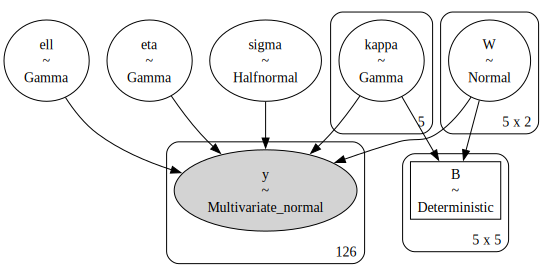

In [64]:
with pm.Model() as icm_model:
    # Temporal kernel parameters
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    
    # Base kernel on time (active_dims=[0])
    kernel_time = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    # Coregionalization parameters
    W = pm.Normal("W", mu=0, sigma=3, shape=(n_outputs, 2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=n_outputs)
    
    # Track B matrix
    B = pm.Deterministic("B", pt.dot(W, W.T) + pt.diag(kappa))
    
    # ICM kernel
    cov_icm = get_icm(input_dim=2, kernel=kernel_time, W=W, kappa=kappa, active_dims=[1])
    
    # GP with increased jitter for numerical stability
    gp = pm.gp.Marginal(cov_func=cov_icm)
    
    # Noise
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Likelihood with increased jitter (1e-3 for robustness with sparse data)
    y_obs = gp.marginal_likelihood("y", X=X_train, y=y_train, sigma=sigma, jitter=1e-3)

pm.model_to_graphviz(icm_model)

### Sampling the Posterior

This may take a few minutes...

In [65]:
with icm_model:
    trace_icm = pm.sample(
        500,
        tune=500,
        nuts_sampler="nutpie",
        random_seed=RANDOM_SEED,
        chains=2,
        target_accept=0.9
    )

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method



Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.27,15
,1000,0,0.25,63


Let's check convergence:

In [66]:
summary = az.summary(trace_icm, var_names=["ell", "eta", "sigma", "kappa"])
print(f"R-hat: [{summary['r_hat'].min():.4f}, {summary['r_hat'].max():.4f}]")
print(f"ESS: [{summary['ess_bulk'].min():.0f}, {summary['ess_bulk'].max():.0f}]")
print("\nEstimates:")
print(summary[["mean", "sd", "hdi_3%", "hdi_97%"]])

R-hat: [1.0000, 1.0000]
ESS: [492, 1614]

Estimates:
            mean     sd  hdi_3%  hdi_97%
ell       25.214  5.057  16.565   34.898
eta        0.253  0.077   0.135    0.396
sigma      0.259  0.020   0.222    0.298
kappa[0]   1.692  1.229   0.046    3.942
kappa[1]   0.992  0.873   0.005    2.554
kappa[2]   1.706  1.321   0.012    4.058
kappa[3]   1.746  1.274   0.005    4.002
kappa[4]   1.295  0.986   0.022    3.015


Good convergence! The model has learned temporal dynamics and output correlations simultaneously.

Now let's make predictions.

### Posterior Predictions

Create test grid for all 5 pitchers:

In [67]:
# Test data: 200 time points
n_test = 200
time_test = np.linspace(0, 199, n_test)

# Stack for all outputs
X_test_list = []
for out_idx in range(n_outputs):
    X_out = np.column_stack([time_test, np.full(n_test, out_idx)])
    X_test_list.append(X_out)

X_test = np.vstack(X_test_list)
print(f"Test shape: {X_test.shape}")

Test shape: (1000, 2)


In [68]:
with icm_model:
    f_pred = gp.conditional("f_pred", X_test, jitter=1e-3)
    ppc_icm = pm.sample_posterior_predictive(
        trace_icm,
        var_names=["f_pred"],
        random_seed=RANDOM_SEED
    )

Sampling: [f_pred]


Output()

### Visualizing Multi-Output Predictions

Plot posterior for each pitcher:

In [69]:
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=top_pitchers,
    vertical_spacing=0.05,
    shared_xaxes=True
)

for i, pitcher in enumerate(top_pitchers):
    # Extract predictions for this output
    f_pred_i = ppc_icm.posterior_predictive["f_pred"].isel(
        f_pred_dim_0=slice(i*n_test, (i+1)*n_test)
    )
    
    mean = f_pred_i.mean(dim=["chain", "draw"]).values
    lower = np.percentile(f_pred_i.values, 2.5, axis=(0,1))
    upper = np.percentile(f_pred_i.values, 97.5, axis=(0,1))
    
    # HDI band
    fig.add_trace(go.Scatter(
        x=time_test, y=upper, line=dict(width=0),
        showlegend=False, hoverinfo='skip'
    ), row=i+1, col=1)
    
    fig.add_trace(go.Scatter(
        x=time_test, y=lower, fill='tonexty',
        line=dict(width=0), showlegend=False,
        fillcolor='rgba(135,206,250,0.3)'
    ), row=i+1, col=1)
    
    # Mean
    fig.add_trace(go.Scatter(
        x=time_test, y=mean, mode='lines',
        line=dict(color='steelblue', width=2),
        showlegend=False
    ), row=i+1, col=1)
    
    # Training data
    pitcher_data = df_train.filter(pl.col("pitcher_name") == pitcher)
    fig.add_trace(go.Scatter(
        x=pitcher_data["game_date_idx"].to_list(),
        y=pitcher_data["avg_spin_rate_std"].to_list(),
        mode='markers',
        marker=dict(color='red', size=3),
        showlegend=False
    ), row=i+1, col=1)

fig.update_xaxes(title_text="Days Since Season Start", row=5, col=1)
fig.update_layout(height=1000, title_text="ICM Posterior Predictions")
fig.show()

Notice how the model smooths noisy observations while respecting each pitcher's unique pattern. The uncertainty (shaded regions) is wider where data is sparse and narrower where we have more observations—exactly what we want from a principled probabilistic model.

**Why ICM matters here**: Compared to fitting 5 independent GPs, the ICM learns a **shared lengthscale** (≈25 days) and **shared amplitude** across all pitchers. This means pitchers with fewer observations (like Ross with 20 games) benefit from information borrowed from data-rich pitchers (like Lyles with 32 games) when estimating temporal smoothness. The result: more stable predictions and better uncertainty quantification, especially for pitchers with sparse data.

Now let's examine what the model learned about correlations between pitchers.

### The Coregionalization Matrix: Who's Correlated?

Extract learned $B$ matrix:

In [70]:
# Posterior mean of B
B_post = az.extract(trace_icm, var_names=["B"]).mean(dim="sample").values

# Heatmap
fig = go.Figure(data=go.Heatmap(
z=B_post,
x=top_pitchers,
y=top_pitchers,
colorscale='RdBu',
zmid=0,
text=np.round(B_post, 2),
texttemplate='%{text}',
textfont={"size": 10}
))

fig.update_layout(
title="Learned Coregionalization Matrix B",
xaxis_title="Pitcher",
yaxis_title="Pitcher",
height=450
)
fig.show()

# Convert to correlation
std_devs = np.sqrt(np.diag(B_post))
corr = B_post / np.outer(std_devs, std_devs)
print("\nCorrelations:")
print(corr)


Correlations:
[[ 1.          0.53904452 -0.49589423  0.64337521  0.03388497]
 [ 0.53904452  1.         -0.31903694  0.70427474  0.25519911]
 [-0.49589423 -0.31903694  1.         -0.32743202  0.41983488]
 [ 0.64337521  0.70427474 -0.32743202  1.          0.32092721]
 [ 0.03388497  0.25519911  0.41983488  0.32092721  1.        ]]


The diagonal elements show each pitcher's variance (their own variability), while off-diagonal elements reveal shared variation. High positive values mean those pitchers' spin rates tend to fluctuate together—perhaps they have similar mechanics or respond similarly to external factors like weather.

This is the power of multi-output GPs: we're not just smoothing trajectories, we're **learning the latent structure** of how outputs relate.

## Linear Coregionalization Model (LCM)

The ICM assumes a **single shared temporal process** drives all output correlations. But what if variation happens at multiple timescales?

Consider pitcher spin rates again:
- **Long-term trends**: Gradual changes from aging, mechanics adjustments (weeks to months)
- **Short-term fluctuations**: Game-to-game variation from fatigue, matchups, measurement noise (days)

ICM can't distinguish these. It learns one lengthscale and applies the same coregionalization to all frequencies.

**LCM extends ICM** by summing multiple coregionalized kernels:

$$K_{LCM} = B_1 \otimes K_1 + B_2 \otimes K_2 + \cdots$$

Each kernel can have its own lengthscale (capturing different timescales), while the coregionalization matrices learn how outputs correlate at each scale. In our implementation, we'll use shared $B$ across kernels for simplicity, but the different input kernels still capture multi-scale variation.

### When to Use LCM Over ICM

**Use ICM when:**
- Single timescale dominates
- Simplicity is priority
- Limited data

**Use LCM when:**
- Multiple timescales evident
- Different correlations at different scales
- Sufficient data for complexity

For baseball, we might combine:
- ExpQuad: smooth long-term trends
- Matern32: short-term wiggles

In [71]:
def get_lcm(input_dim, active_dims, num_outputs, kernels, W=None, kappa=None, B=None, name="LCM"):
    """
    Construct Linear Coregionalization Model kernel.
    
    Sums multiple ICM kernels.
    """
    if B is None:
        if kappa is None:
            kappa = pm.Gamma(f"{name}_kappa", alpha=5, beta=1, shape=num_outputs)
        if W is None:
            W = pm.Normal(f"{name}_W", mu=0, sigma=5, shape=(num_outputs, 1))
    else:
        kappa = None
    
    # Sum ICMs
    cov_lcm = 0
    for kernel in kernels:
        icm = get_icm(input_dim, kernel, W, kappa, B, active_dims)
        cov_lcm += icm
    
    return cov_lcm

print("✓ LCM helper defined")

✓ LCM helper defined


This implementation reuses the same $W$ and $\kappa$ across both kernels (shared coregionalization structure), but each kernel contributes its own input covariance shape. The ExpQuad kernel will capture smooth long-term trends, while the Matérn32 kernel will capture rougher short-term wiggles.

Let's see this in action:

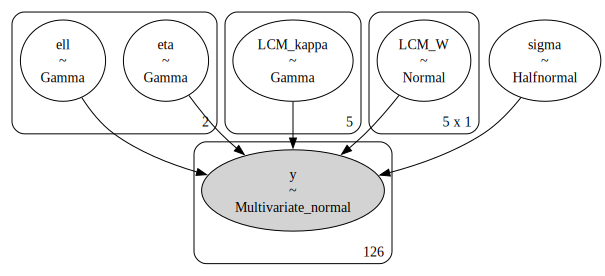

In [72]:
with pm.Model() as lcm_model:
    # Two lengthscales
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    
    # Two kernels
    kernel_list = [
        eta[0]**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell[0], active_dims=[0]),
        eta[1]**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell[1], active_dims=[0])
    ]
    
    # LCM kernel
    cov_lcm = get_lcm(input_dim=2, active_dims=[1], num_outputs=n_outputs,
                      kernels=kernel_list, name="LCM")
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov_lcm)
    sigma = pm.HalfNormal("sigma", sigma=3)
    y_obs = gp.marginal_likelihood("y", X=X_train, y=y_train, sigma=sigma)

pm.model_to_graphviz(lcm_model)

In [73]:
with lcm_model:
    trace_lcm = pm.sample(
        500,
        tune=500,
        nuts_sampler="nutpie",
        random_seed=RANDOM_SEED,
        chains=2,
        target_accept=0.9
    )

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method



Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.28,15
,1000,0,0.28,15


The LCM has more parameters than ICM (two lengthscales, two amplitudes) but maintains shared coregionalization. This added flexibility allows the model to capture both smooth seasonal trends and short-term game-to-game fluctuations—though it comes at the cost of increased computational complexity and potential overfitting if data is limited.

In [74]:
with lcm_model:
    f_pred_lcm = gp.conditional("f_pred", X_test)
    ppc_lcm = pm.sample_posterior_predictive(
        trace_lcm,
        var_names=["f_pred"],
        random_seed=RANDOM_SEED
    )

Sampling: [f_pred]


Output()

### Visualizing LCM Multi-Output Predictions

Just as we did for the ICM, let's visualize the LCM posterior predictions for each pitcher to compare how the multi-timescale model captures the data:

In [75]:
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=top_pitchers,
    vertical_spacing=0.05,
    shared_xaxes=True
)

for i, pitcher in enumerate(top_pitchers):
    # Extract predictions for this output
    f_pred_i = ppc_lcm.posterior_predictive["f_pred"].isel(
        f_pred_dim_0=slice(i*n_test, (i+1)*n_test)
    )
    
    mean = f_pred_i.mean(dim=["chain", "draw"]).values
    lower = np.percentile(f_pred_i.values, 2.5, axis=(0,1))
    upper = np.percentile(f_pred_i.values, 97.5, axis=(0,1))
    
    # HDI band
    fig.add_trace(go.Scatter(
        x=time_test, y=upper, line=dict(width=0),
        showlegend=False, hoverinfo='skip'
    ), row=i+1, col=1)
    
    fig.add_trace(go.Scatter(
        x=time_test, y=lower, fill='tonexty',
        line=dict(width=0), showlegend=False,
        fillcolor='rgba(255,165,0,0.3)'  # Orange shade to distinguish from ICM
    ), row=i+1, col=1)
    
    # Mean
    fig.add_trace(go.Scatter(
        x=time_test, y=mean, mode='lines',
        line=dict(color='darkorange', width=2),
        showlegend=False
    ), row=i+1, col=1)
    
    # Training data
    pitcher_data = df_train.filter(pl.col("pitcher_name") == pitcher)
    fig.add_trace(go.Scatter(
        x=pitcher_data["game_date_idx"].to_list(),
        y=pitcher_data["avg_spin_rate_std"].to_list(),
        mode='markers',
        marker=dict(color='red', size=3),
        showlegend=False
    ), row=i+1, col=1)

fig.update_xaxes(title_text="Days Since Season Start", row=5, col=1)
fig.update_layout(height=1000, title_text="LCM Posterior Predictions")
fig.show()

The LCM predictions show similar smoothing behavior to ICM but with potentially different dynamics due to the two-kernel structure. The ExpQuad kernel captures smooth long-term trends while the Matérn32 kernel handles shorter-term variations.

**Comparing ICM vs LCM visually**: Look for differences in how the models handle:
- **Smoothness**: LCM may show slightly different smoothness characteristics due to the Matérn32 component
- **Uncertainty**: The credible intervals (shown in orange) might differ in width, especially in regions with sparse data
- **Trend capture**: LCM's dual-kernel structure may pick up multi-scale patterns that ICM averages over

The key question is whether this added modeling flexibility translates to meaningfully better predictions or if it introduces unnecessary complexity for this particular dataset. Notice that both models effectively smooth the noisy observations while quantifying uncertainty—the choice between them often depends on whether multiple distinct timescales are evident in your data.

## Summary: Multi-Output Gaussian Processes

In this session, we explored how to model **multiple related outputs jointly** using multi-output Gaussian processes:

### Intrinsic Coregionalization Model (ICM)

- **Core idea**: Combine input covariance with output coregionalization using the Hadamard product: $K_{ICM} = K_{input} \times B$
- **Coregionalization matrix**: $B = WW^T + \text{diag}(\kappa)$ learns how outputs correlate
- **Benefits**: Information sharing across outputs, improved predictions for data-scarce outputs, uncertainty quantification
- **Application**: Modeled 5 baseball pitchers' spin rates, discovering correlation patterns

### Linear Coregionalization Model (LCM)

- **Extension**: Sum multiple ICM kernels to capture **multiple timescales**
- **Flexibility**: Different kernels (ExpQuad for smooth trends, Matérn for rough variations) capture different dynamics
- **Trade-off**: More parameters mean more flexibility but also higher computational cost and potential overfitting

### Key Takeaways

1. **Borrowing strength**: Multi-output GPs pool information across related outputs, leading to more stable estimates
2. **Learning structure**: The coregionalization matrix reveals which outputs co-vary
3. **Scalability**: These methods work with PyMC's marginal likelihood for efficient exact inference
4. **When to use**: ICM for single timescale, LCM when multiple distinct timescales are evident

**Next**: In Session 4B, we'll see how to integrate multi-scale GPs with hierarchical models in a complete case study of soccer player skill estimation.